# Quantum Circuits for Laughlin States
### Exact ground state preparation of the fractional quantum Hall effect

*In this notebook, we will present the explicit circuits creating the $n$-particle Laughlin state, with an efficient number of local qubit gates. These circuits can be run in both simulators and real quantum devices. Furthermore, we are going to present several tools for characterizing these states, such as quantum state tomography or a hybrid variational quantum-classical algorithm for computing the Von Neumann entropy of the bipartition. Implicitly, we are going to learn how to work with qudits, how to measure in a non-trivial basis other than the computational-basis, and how to implement variational quantum algorithms.*

*Note: this notebook was executed on 10/22/2019 at 11:00 a.m. (CET)*

___


#### Contributors

Carlos Bravo-Prieto

## Introduction
---

Strongly-correlated many-body systems can give rise to exceptional quantum phenomena. In particular, quantum Hall systems have fundamental significance in condensed matter physics, and thus the experimental realization of these systems may attract tremendous interest. It is then an ambitious goal to prepare the groundstate of quantum Hall systems experimentally to gain some insight into the physics of the problem. In the digital quantum computation paradigm, it would be ideal to implement *exact quantum circuits* preparing such groundstates.

This idea was carried out by Latorre, Picó and Riera [[1](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.81.060309)]: they proposed a quantum algorithm that creates the Laughlin state for an arbitrary number of particles $n$ in the case of filling fraction one, *i.e.* ratio between the number of electrons and the number of flux quanta equal to one. Recall that this state was postulated by Laughlin as the ground state of the fractional quantum Hall effect, and the wave function for filling fraction $\nu = 1/m$ corresponds to

$$
\psi_L(z_1,...,z_n) \sim \prod_{i<j} (z_i - z_j)^m e^{-\sum_{i=1}^N |z_i^2|/2}\,,
$$

where $z_j=x_j + iy_j$, $\,j=1,...,n$ stands for the position of the $j$th particle.

Nowadays, the real implementation of these circuits is becoming possible in platforms such as IBMQ. In this notebook, the quantum circuits presented will transform a trivial product state into a Laughlin state with filling fraction one using a finite amount of local two-qubit quantum gates. In particular, this quantum circuit only uses $O(n^2)$ local qudit gates and its depth scales as $O(n)$.

## Two-particle Laughlin state
 
We may construct a Laughlin state of $n$ particles using a quantum system consisting of $n$ *qudits* with local dimension $n$. Recall that a *qudit* is a $d$-dimensional quantum system, where the *qubit* is the particular case with $d=2$.

#### Groundstate preparation

Let's proceed to construct the quantum circuit by first considering the case of $n=2$ particles. The Laughlin state can be written in terms of the single particle angular momentum eigenstates, and for the $n=2$ case reads

$$
\left| \psi^{(2)}_L\right\rangle = \frac{1}{\sqrt{2}}\left(\left|0,1\right\rangle - \left|1,0\right\rangle\right)\,,
$$

where the angular momentum $0$ or $1$ is an element of the angular momentum basis.

The construction of the Laughlin state for $n=2$ consists on applying a two-qubit unitary operation $U[2]$ on a trivial initial state $\left|\psi \right\rangle = \left|0,1\right\rangle$. The form of the unitary operator $U[2]$ in the angular momentum basis $\left \{\left|0,0\right\rangle,\left|0,1\right\rangle,\left|1,0\right\rangle,\left|1,1\right\rangle\right\}$ is

$$
U[2] =  \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & \frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & 0 \\
0 & -\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & 0 \\
0 & 0 & 0 & 1
\end{pmatrix}
$$


<img src="U2_circ.png" width="270px">


<img src="cRY_circuit_theta.png" width="350px">

where $RY$ is the rotation gate in the $Y$ axis, and the above decomposition of the controlled-$RY$ gate has been obtained from Ref. [[2](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.52.3457)]. The unitary operation $U[2]$ can be seen as a partial swap gate, where the swaped qubits do not perform a complete transfer of their corresponding amplitudes.

In [1]:
# cRY
def cRY(qcirc,theta,q0,q1):
    # theta: angle
    # q0: control
    # q1: target
    qcirc.ry(theta/2.0, q1)
    qcirc.cx(q0,q1)
    qcirc.ry(-1.0*theta/2.0, q1)
    qcirc.cx(q0,q1)
    

# U[2]
def U2(qcirc,theta,q0,q1):
    # theta: angle
    qcirc.cx(q1,q0)
    cRY(qcirc,theta,q0,q1)
    qcirc.cx(q1,q0)

The full circuit reads

<img src="full_circuit_n2.png" width="440px">

As the qubits are initialized in the $\left|0\right\rangle$ state, it is then necessary to apply a $X$-gate to prepare the initial state $\left|\psi \right\rangle = \left|0,1\right\rangle$. 
Now, we may simplify the circuit preparing the Laughlin state for $n=2$ as much as possible. In particular, the circuit can be simplified as

<img src="circuit_n2_simp.png" width="260px">

One exercise that might be interesting before continuing could be to obtain the simplified circuit from the aforementioned full circuit. Recall that this simplification might not be possible in the following examples for $n > 2$, because a similar operation to $U[2]$ acts sequentially as an essential building block. Therefore, it is necessary to have the explicit full circuit.

In [2]:
def simp_circ(qcirc,q0,q1):
    # prepare the initial |0,1> state
    qcirc.x(q0)
    # apply simplified circuit
    qcirc.x(q1)
    qcirc.h(q1)
    qcirc.cx(q1,q0)

In [3]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor

### simulator ###

# create a quantum circuit acting on a quantum register of two qubits
qcircuit_sim = QuantumCircuit(2, 2)

# prepare the initial |0,1> state
qcircuit_sim.x(1)

# apply U[2]
U2(qcircuit_sim, np.pi/2, 0, 1)

qcircuit_sim.measure(range(2),range(2))

# use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# execute the circuit on the qasm simulator.
# we've set the number of repeats of the circuit
# to be 1024, which is the default
job_sim = execute(qcircuit_sim, backend_sim)

# grab the results from the job.
result_sim = job_sim.result()

counts = result_sim.get_counts(qcircuit_sim)

Job Status: job has successfully run


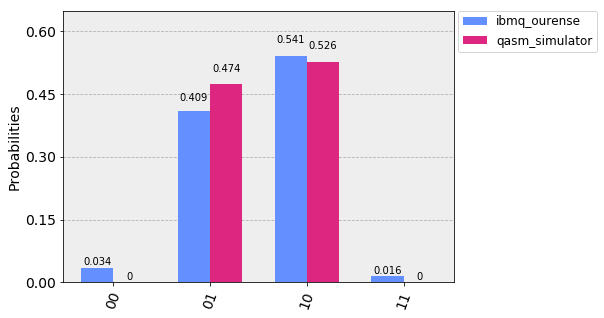

In [4]:
### ibmq_ourense ###

#IBMQ.save_account('MY TOKEN')
IBMQ.load_account()
IBMQ.providers()
provider = IBMQ.get_provider(group='open')
provider.backends()

# create a quantum circuit acting on a quantum register of two qubits
qcircuit_exp = QuantumCircuit(2, 2)

# apply simplified quantum circuit
simp_circ(qcircuit_exp,0,1)

qcircuit_exp.measure(range(2),range(2))

# use quantum device
backend = provider.get_backend('ibmq_ourense')

# execute the circuit on the quantum device.
# we've set the number of repeats of the circuit
# to be 1024, which is the default
job_exp = execute(qcircuit_exp, backend=backend)
job_monitor(job_exp)

# grab the results from the job.
result_exp = job_exp.result()

counts_exp = result_exp.get_counts(qcircuit_exp)


# plot results
plot_histogram([counts_exp,counts], legend=['ibmq_ourense', 'qasm_simulator'])

#### Quantum state tomography

From the previous results, one can not fully indentify the quantum state. For instance, we may not be able to distinguish between $\left|\psi\right\rangle = \frac{1}{\sqrt{2}}\left(\left|0,1\right\rangle - \left|1,0\right\rangle\right)$ and $\left|\psi\right\rangle = \frac{1}{\sqrt{2}}\left(\left|0,1\right\rangle + i\left|1,0\right\rangle\right)$. 

Quantum state tomography is the process of reconstructing the quantum state by measurements on the system. To be able to fully characterize the state, the measured operators must form an operator-basis on the Hilbert space of the system, providing all the information about the state. In our particular case, we need to compute the expectation value of $4^2-1$ observables, *i.e.* all the combinations of Pauli operators and the Identity $\{I, \sigma_x, \sigma_y, \sigma_z\}$. Since $\{\sigma_x, \sigma_y, \sigma_z\}$ commute with $I$, we only have to measure $3^2$ observables.

Measurements can only be done on the $\sigma_z$ basis. Nonetheless, they can be simulated in another basis with the help of additional gates, namely an $H$-gate for $\sigma_x$ and an $S^\dagger$-gate followed by an $H$-gate for $\sigma_y$

$$
H^\dagger Z H = X\,,\,\,\,\,\,\,\,\,\,\,\,\,
S H^\dagger Z H S^\dagger = Y\,.
$$

In [5]:
# measuring in X
def measX(qcirc,q0):
    qcirc.h(q0)
    qcirc.measure(q0,q0)

# measuring in Y
def measY(qcirc,q0):
    qcirc.sdg(q0)
    qcirc.h(q0)
    qcirc.measure(q0,q0)

In [6]:
### simulator and ibmq_ourense ###

shots=1024

"measuring ZZ, ZI, IZ"
qcircuit = QuantumCircuit(2, 2)
simp_circ(qcircuit,0,1)
qcircuit.measure(range(2),range(2))

## simulator
job_sim = execute(qcircuit, backend=Aer.get_backend('qasm_simulator'), shots=shots)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qcircuit)
# computing expectation value
expectation_ZZ_sim = (-counts_sim['01']-counts_sim['10'])/shots
expectation_IZ_sim = (-counts_sim['01']+counts_sim['10'])/shots
expectation_ZI_sim = (counts_sim['01']-counts_sim['10'])/shots

## ibmq_ourense
job_exp = execute(qcircuit, backend=provider.get_backend('ibmq_ourense'), shots=shots)
job_monitor(job_exp)
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qcircuit)
# computing expectation value
expectation_ZZ_exp = (counts_exp['00']-counts_exp['01']-counts_exp['10']+counts_exp['11'])/shots
expectation_IZ_exp = (counts_exp['00']-counts_exp['01']+counts_exp['10']-counts_exp['11'])/shots
expectation_ZI_exp = (counts_exp['00']+counts_exp['01']-counts_exp['10']-counts_exp['11'])/shots


"measuring XX, XI, IX"
qcircuit = QuantumCircuit(2, 2)
simp_circ(qcircuit,0,1)
measX(qcircuit,0)
measX(qcircuit,1)

## simulator
job_sim = execute(qcircuit, backend=Aer.get_backend('qasm_simulator'), shots=shots)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qcircuit)
# computing expectation value
expectation_XX_sim = (-counts_sim['01']-counts_sim['10'])/shots
expectation_IX_sim = (-counts_sim['01']+counts_sim['10'])/shots
expectation_XI_sim = (counts_sim['01']-counts_sim['10'])/shots

## ibmq_ourense
job_exp = execute(qcircuit, backend=provider.get_backend('ibmq_ourense'), shots=shots)
job_monitor(job_exp)
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qcircuit)
# computing expectation value
expectation_XX_exp = (counts_exp['00']-counts_exp['01']-counts_exp['10']+counts_exp['11'])/shots
expectation_IX_exp = (counts_exp['00']-counts_exp['01']+counts_exp['10']-counts_exp['11'])/shots
expectation_XI_exp = (counts_exp['00']+counts_exp['01']-counts_exp['10']-counts_exp['11'])/shots


"measuring YY, YI, IY"
qcircuit = QuantumCircuit(2, 2)
simp_circ(qcircuit,0,1)
measY(qcircuit,0)
measY(qcircuit,1)

## simulator
job_sim = execute(qcircuit, backend=Aer.get_backend('qasm_simulator'), shots=shots)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qcircuit)
# computing expectation value
expectation_YY_sim = (-counts_sim['01']-counts_sim['10'])/shots
expectation_IY_sim = (-counts_sim['01']+counts_sim['10'])/shots
expectation_YI_sim = (counts_sim['01']-counts_sim['10'])/shots

## ibmq_ourense
job_exp = execute(qcircuit, backend=provider.get_backend('ibmq_ourense'), shots=shots)
job_monitor(job_exp)
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qcircuit)
# computing expectation value
expectation_YY_exp = (counts_exp['00']-counts_exp['01']-counts_exp['10']+counts_exp['11'])/shots
expectation_IY_exp = (counts_exp['00']-counts_exp['01']+counts_exp['10']-counts_exp['11'])/shots
expectation_YI_exp = (counts_exp['00']+counts_exp['01']-counts_exp['10']-counts_exp['11'])/shots


"measuring ZX"
qcircuit = QuantumCircuit(2, 2)
simp_circ(qcircuit,0,1)
qcircuit.measure(0,0)
measX(qcircuit,1)

## simulator
job_sim = execute(qcircuit, backend=Aer.get_backend('qasm_simulator'), shots=shots)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qcircuit)
# computing expectation value
expectation_ZX_sim = (counts_sim['00']-counts_sim['01']-counts_sim['10']+counts_sim['11'])/shots

## ibmq_ourense
job_exp = execute(qcircuit, backend=provider.get_backend('ibmq_ourense'), shots=shots)
job_monitor(job_exp)
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qcircuit)
# computing expectation value
expectation_ZX_exp = (counts_exp['00']-counts_exp['01']-counts_exp['10']+counts_exp['11'])/shots


"measuring ZY"
qcircuit = QuantumCircuit(2, 2)
simp_circ(qcircuit,0,1)
qcircuit.measure(0,0)
measY(qcircuit,1)

## simulator
job_sim = execute(qcircuit, backend=Aer.get_backend('qasm_simulator'), shots=shots)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qcircuit)
# computing expectation value
expectation_ZY_sim = (counts_sim['00']-counts_sim['01']-counts_sim['10']+counts_sim['11'])/shots

## ibmq_ourense
job_exp = execute(qcircuit, backend=provider.get_backend('ibmq_ourense'), shots=shots)
job_monitor(job_exp)
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qcircuit)
# computing expectation value
expectation_ZY_exp = (counts_exp['00']-counts_exp['01']-counts_exp['10']+counts_exp['11'])/shots


"measuring XZ"
qcircuit = QuantumCircuit(2, 2)
simp_circ(qcircuit,0,1)
qcircuit.measure(1,1)
measX(qcircuit,0)

## simulator
job_sim = execute(qcircuit, backend=Aer.get_backend('qasm_simulator'), shots=shots)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qcircuit)
# computing expectation value
expectation_XZ_sim = (counts_sim['00']-counts_sim['01'])/shots

## ibmq_ourense
job_exp = execute(qcircuit, backend=provider.get_backend('ibmq_ourense'), shots=shots)
job_monitor(job_exp)
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qcircuit)
# computing expectation value
expectation_XZ_exp = (counts_exp['00']-counts_exp['01']-counts_exp['10']+counts_exp['11'])/shots


"measuring XY"
qcircuit = QuantumCircuit(2, 2)
simp_circ(qcircuit,0,1)
measX(qcircuit,0)
measY(qcircuit,1)

## simulator
job_sim = execute(qcircuit, backend=Aer.get_backend('qasm_simulator'), shots=shots)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qcircuit)
# computing expectation value
expectation_XY_sim = (counts_sim['00']-counts_sim['01']-counts_sim['10']+counts_sim['11'])/shots

## ibmq_ourense
job_exp = execute(qcircuit, backend=provider.get_backend('ibmq_ourense'), shots=shots)
job_monitor(job_exp)
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qcircuit)
# computing expectation value
expectation_XY_exp = (counts_exp['00']-counts_exp['01']-counts_exp['10']+counts_exp['11'])/shots


"measuring YZ"
qcircuit = QuantumCircuit(2, 2)
simp_circ(qcircuit,0,1)
qcircuit.measure(1,1)
measY(qcircuit,0)

## simulator
job_sim = execute(qcircuit, backend=Aer.get_backend('qasm_simulator'), shots=shots)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qcircuit)
# computing expectation value
expectation_YZ_sim = (counts_sim['00']-counts_sim['01'])/shots

## ibmq_ourense
job_exp = execute(qcircuit, backend=provider.get_backend('ibmq_ourense'), shots=shots)
job_monitor(job_exp)
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qcircuit)
# computing expectation value
expectation_YZ_exp = (counts_exp['00']-counts_exp['01']-counts_exp['10']+counts_exp['11'])/shots


"measuring YX"
qcircuit = QuantumCircuit(2, 2)
simp_circ(qcircuit,0,1)
measY(qcircuit,0)
measX(qcircuit,1)

## simulator
job_sim = execute(qcircuit, backend=Aer.get_backend('qasm_simulator'), shots=shots)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qcircuit)
# computing expectation value
expectation_YX_sim = (counts_sim['00']-counts_sim['01']-counts_sim['10']+counts_sim['11'])/shots

## ibmq_ourense
job_exp = execute(qcircuit, backend=provider.get_backend('ibmq_ourense'), shots=shots)
job_monitor(job_exp)
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qcircuit)
# computing expectation value
expectation_YX_exp = (counts_exp['00']-counts_exp['01']-counts_exp['10']+counts_exp['11'])/shots

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


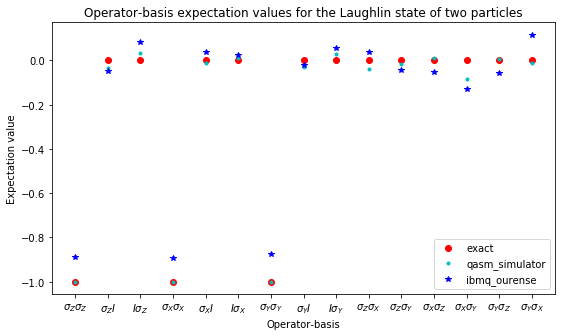

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot results
observables = np.linspace(0,14,15)
expectation_sim = [expectation_ZZ_sim,expectation_ZI_sim,expectation_IZ_sim,expectation_XX_sim,
                  expectation_XI_sim,expectation_IX_sim,expectation_YY_sim,expectation_YI_sim,
                  expectation_IY_sim,expectation_ZX_sim,expectation_ZY_sim,expectation_XZ_sim,
                  expectation_XY_sim,expectation_YZ_sim,expectation_YX_sim]
expectation_exp = [expectation_ZZ_exp,expectation_ZI_exp,expectation_IZ_exp,expectation_XX_exp,
                  expectation_XI_exp,expectation_IX_exp,expectation_YY_exp,expectation_YI_exp,
                  expectation_IY_exp,expectation_ZX_exp,expectation_ZY_exp,expectation_XZ_exp,
                  expectation_XY_exp,expectation_YZ_exp,expectation_YX_exp]
exact = [-1.0, 0, 0, -1.0, 0, 0, -1.0, 0, 0, 0, 0, 0, 0, 0, 0]

plt.figure(figsize=(9,5))
plt.plot(observables,exact, 'r o',label='exact')
plt.plot(observables,expectation_sim,'c.',label='qasm_simulator')
plt.plot(observables,expectation_exp, 'b*',label='ibmq_ourense')
plt.xlabel('Operator-basis')
plt.ylabel('Expectation value')
plt.legend()
plt.title('Operator-basis expectation values for the Laughlin state of two particles')
plt.xticks(observables, ('$\sigma_Z\sigma_Z$', '$\sigma_ZI$', '$I\sigma_Z$', '$\sigma_X\sigma_X$',
                         '$\sigma_XI$', '$I\sigma_X$', '$\sigma_Y\sigma_Y$', '$\sigma_YI$',
                         '$I\sigma_Y$', '$\sigma_Z\sigma_X$', '$\sigma_Z\sigma_Y$', '$\sigma_X\sigma_Z$',
                         '$\sigma_X\sigma_Y$', '$\sigma_Y\sigma_Z$', '$\sigma_Y\sigma_X$'))
plt.show()

From the previous results we can observe two things: 

(1) The impact of finite sampling in *qasm_simulator* respect to the exact value. 

(2) We can indeed verify that the expectation values obtained from the operator-basis correspond to the Laughlin state $\left|\psi^{(2)}_L\right\rangle = \frac{1}{\sqrt{2}}\left(\left|0,1\right\rangle - \left|1,0\right\rangle\right)$.

#### Variational Quantum Singular Value Decomposer

As we have seen, performing Quantum State Tomography may be out of reach as we increase the number of qubits of the system, since it scales as $O(4^n)$. In order to characterize the state without performing the aforementioned technique, we can obtain the singular values and singular vectors of a bipartition by means of a variational quantum algorithm. Once we have the singular values, we can compute, for instance, the Von Neumann entropy of the bipartition. In this section, we are going to apply the Quantum Singular Value Decomposer from Ref. [[3](https://arxiv.org/abs/1905.01353)] to the two-particle Laughlin state. One can generalize this algorithm to any $n$-particle Laughlin state, avoiding quantum state tomography if fully characterization of the state is not needed.

The variational Quantum Singular Value Decomposer consists of two circuits acting on the separate subparts of the system, and can be determined in a variational way. The key idea is to train the circuits on *exact output coincidence*. The frequencies of the outputs of the final state in the circuit deliver the eigenvalues of the decomposition without further treatment. Suppose that we have a quantum state of the following form $\left|\psi\right\rangle_{AB} = \sum_{j=1}^\chi \lambda_j \left| u_j\right\rangle_A\left| v_j\right\rangle_B$, where $\chi$ is the Schmidt rank, $A$ and $B$ are the two subsystems, $\lambda_j$ are the singular values of the bipartition and $\left| u_j\right\rangle_A$ and $\left| v_j\right\rangle_B$ are the singular vectors. The Quantum Singular Value Decomposer acts on the quantum state as

$$
U_A(\Theta) \otimes V_B(\Omega)\sum_{j=1}^\chi \lambda_j \left| u_j\right\rangle_A\left| v_j\right\rangle_B = \sum_{j=1}^\chi \lambda_j e^{i\alpha_j}\left| e_j\right\rangle_A\left| e_j\right\rangle_B\,,
$$

where $U_A(\Theta) \otimes V_B(\Omega)$ are the variational circuits acting on each part of the subsystem, $e^{i\alpha_j}$ is just an introduced phase and $\left| e_j\right\rangle$ are the computational-basis vectors. Thus, the Singular Value Decomposer performs a change of basis, from the Schmidt-basis to the computational-basis, by demanding *exact output coincidence*. Note that we can now obtain the singular values just from the outcome probability of each of the computational-basis vectors of a subsystem.

<img src="QSVD.png" width="370px">

When training the circuit, at the outset, random values for the parameters are used, and the circuit does not issue states that show exact output coincidence for all measurements. A figure of merit for the wrong answer is simply the total amount of non-coincidental measurement outcomes, which shall be minimized using standard machine learning techniques.

In [8]:
from scipy.optimize import minimize

# variational circuits acting on each subsystem
# each subsystem has only one qubit, therefore our
# unitary operation consists on single qubit rotations
def ansatz(params, qcirc):
    qcirc.ry(params[0], 0)
    qcirc.ry(params[1], 1)
    
# compute cost function, which shall be minimized
# based on non-coincidental measurement outcomes
def cost_function_simulator(params, backend):
    qcircuit = QuantumCircuit(2, 2)
    
    # create the two-particle Laughlin state
    simp_circ(qcircuit, 0, 1)
    
    # apply variational circuit
    ansatz(params, qcircuit)
    
    qcircuit.measure(range(2), range(2))
    
    backend = Aer.get_backend(backend)
    job = execute(qcircuit, backend)
    result = job.result()
    counts = result.get_counts(qcircuit)
    
    cost = counts.get('01', 0)+counts.get('10', 0)
    print('Cost function value: ',cost)
    
    return cost

def cost_function_ibmq(params, backend):
    qcircuit = QuantumCircuit(2, 2)
    
    # create the two-particle Laughlin state
    simp_circ(qcircuit, 0, 1)
    
    # apply variational circuit
    ansatz(params, qcircuit)
    
    qcircuit.measure(range(2), range(2))
    
    backend = provider.get_backend(backend)
    job = execute(qcircuit, backend)
    result = job.result()
    counts = result.get_counts(qcircuit)
    
    cost = counts.get('01', 0)+counts.get('10', 0)
    print('Cost function value: ',cost)
    
    return cost

In [9]:
### simulator ###

# initial random parameters
initial_params = np.random.uniform(0.0, 2*np.pi, size = 2)

# minimize cost function
result = minimize(cost_function_simulator, initial_params, args=('qasm_simulator'),
                  method='Nelder-Mead', options = {'maxfev': 15})

# compute singular values by the probability outcome 
# of the computational-basis vectors, once
# U and V have been trained
qcircuit = QuantumCircuit(2, 2)
simp_circ(qcircuit,0,1)
ansatz(result.x, qcircuit)
qcircuit.measure(range(2), range(2))
    
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(qcircuit, backend_sim)
result_sim = job_sim.result()
counts_sim = result_sim.get_counts(qcircuit)

sing_val1_sim = counts_sim['00']/shots
sing_val2_sim = counts_sim['11']/shots

# normalized probabilities, we reject
# non-coincidental measurements
norm = sing_val1_sim+sing_val2_sim
sing_val1_sim = sing_val1_sim/norm
sing_val2_sim = sing_val2_sim/norm

Cost function value:  989
Cost function value:  1015
Cost function value:  920
Cost function value:  861
Cost function value:  755
Cost function value:  628
Cost function value:  384
Cost function value:  167
Cost function value:  0
Cost function value:  98
Cost function value:  753
Cost function value:  58
Cost function value:  294
Cost function value:  15
Cost function value:  136
Cost function value:  10


In [10]:
### ibmq_vigo ###

# initial random parameters
initial_params = np.random.uniform(0.0, 2*np.pi, size = 2)

# minimize cost function
result = minimize(cost_function_ibmq, initial_params, args=('ibmq_vigo'), method='Nelder-Mead', 
                  options = {'maxfev': 15})

# compute singular values by the probability outcome 
# of the computational-basis vectors, once
# U and V have been trained
qcircuit = QuantumCircuit(2, 2)
simp_circ(qcircuit,0,1)
ansatz(result.x, qcircuit)
qcircuit.measure(range(2), range(2))
    
backend_exp = provider.get_backend('ibmq_vigo')
job_exp = execute(qcircuit, backend_exp)
result_exp = job_exp.result()
counts_exp = result_exp.get_counts(qcircuit)

sing_val1_exp = counts_exp['00']/shots
sing_val2_exp = counts_exp['11']/shots


# normalized probabilities, we reject
# non-coincidental measurements
norm = sing_val1_exp+sing_val2_exp
sing_val1_exp = sing_val1_exp/norm
sing_val2_exp = sing_val2_exp/norm

Cost function value:  383
Cost function value:  435
Cost function value:  284
Cost function value:  247
Cost function value:  130
Cost function value:  115
Cost function value:  110
Cost function value:  232
Cost function value:  126
Cost function value:  340
Cost function value:  98
Cost function value:  116
Cost function value:  104
Cost function value:  137
Cost function value:  109


We can now compute the Von Neumann entropy from the singular values of the bipartition:

$$
S = \sum_{j=0}^\chi -\lambda_j^2 \log_2 \lambda_j^2\,.
$$

In [11]:
# compute Von Neumann entropy
entropy_sim = -sing_val1_sim*np.log2(sing_val1_sim)-sing_val2_sim*np.log2(sing_val2_sim)
entropy_exp = -sing_val1_exp*np.log2(sing_val1_exp)-sing_val2_exp*np.log2(sing_val2_exp)

print("Exact Von Neumann entropy: ",1.0)
print("Simulated Von Neumann entropy: ",entropy_sim)
print("Experimental Von Neumann entropy: ",entropy_exp)

Exact Von Neumann entropy:  1.0
Simulated Von Neumann entropy:  0.9986677562183464
Experimental Von Neumann entropy:  0.9984270312934379


## Three-particle Laughlin state

The three-particle Laughlin state is more complicated to construct than the previously described $n=2$ case. Now, we have to consider a three-qutrit system $d = n = 3$. 

#### From qudits to qubits

The local dimension of the qudits has to increase as we increase the number of particles. Qudits are present in several fields of quantum computing and quantum information [[4](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.100.022342), [5](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.80.052116)]. Nonetheless, in the available quantum computers, we have to work with qubits. A possible solution consists in mapping the computational-basis of the qudit system to the computational-basis of the qubit system. In particular, for a single qutrit, the computational-basis is $\left \{\left|\tilde{0}\right\rangle,\left|\tilde{1}\right\rangle,\left|\tilde{2}\right\rangle\right\}$. We can now map each qutrit ($d=3$) into two qubits  ($d=2^2=4$). The mapping may read as

$$
\left|\tilde{0}\right\rangle = \left|00\right\rangle\,,
$$
$$
\left|\tilde{1}\right\rangle = \left|01\right\rangle\,,
$$
$$
\left|\tilde{2}\right\rangle = \left|10\right\rangle\,.
$$

Notice that we have freedom in the mapping as long as we are consistent with it. Equivalently, one may map any qudit to a $\lceil \log_2 d \rceil$ qubit system.

#### Groundstate preparation

Similarly to the $n=2$ case, we take as initial state $\left|\psi\right\rangle = \left|\tilde{0},\tilde{1},\tilde{2}\right\rangle$. That is, each qutrit is prepared in a different basis element, representing different angular momenta. Note that we are now working with three qutrits, and therefore we may use six qubits to describe the full quantum state. The aim of the quantum circuit is to prepare the groundstate

$$
\left|\psi^{(3)}_L\right\rangle = \frac{1}{\sqrt{6}}\left(\left|\tilde{0},\tilde{1},\tilde{2}\right\rangle - \left|\tilde{1},\tilde{0},\tilde{2}\right\rangle + \left|\tilde{1},\tilde{2},\tilde{0}\right\rangle - \left|\tilde{2},\tilde{1},\tilde{0}\right\rangle + \left|\tilde{2},\tilde{0},\tilde{1}\right\rangle - \left|\tilde{0},\tilde{2},\tilde{1}\right\rangle\right) = 
$$
$$
= \frac{1}{\sqrt{6}}\left(\left| 00,01,10\right\rangle - \left| 01,00,10\right\rangle + \left| 01,10,00\right\rangle - \left| 10,01,00\right\rangle + \left| 10,00,01\right\rangle - \left| 00,10,01\right\rangle\right)\,.
$$

To do this, we define two-qutrit unitary operators $U_{ij}(p)$ as

$$
U_{ij}(p)\left| ij\right\rangle = \sqrt{p}\left| ij\right\rangle - \sqrt{1-p}\left| ji\right\rangle\,,
$$
$$
U_{ji}(p)\left| ij\right\rangle = \sqrt{p}\left| ji\right\rangle + \sqrt{1-p}\left| ij\right\rangle\,,
$$

for $i < j$, $0 \leq p \leq 1$, and $U_{ij}\left| kl\right\rangle = \left| kl\right\rangle$ if ($k,l$) $\neq$ ($i,j$). Recall that each element $i,j,k,l$ correspond to a two-qubit element described in the aforementioned mapping. Moreover, notice that for the qubit case and $p=1/2$ we recover the gate $U[2]$. The full quantum circuit that produces the $n=3$ Laughlin state is

<img src="n3_circ_qutrit.png" width="550px">

which in the qubit basis corresponds to

<img src="n3_circ_qubit.png" width="550px">


Now, we may explicitly implement each $U_{ij}(p)$ in terms of qubit quantum gates

<img src="full_circuit_n3.png" width="850px">

where the CC-$RY$ gate can be expressed as

<img src="ccRY_circuit_theta.png" width="350px">

and the Toffoli-gate may be decomposed in terms of two-qubit and single-qubit quantum gates

<img src="toffoli.png" width="550px">

We may check that indeed, each $U_{ij}(p)$ performs the operation mentioned above into the quantum state.



In [12]:
# toffoli-gate
def toffoli(qcirc,q0,q1,q2):
    # q0: control
    # q1: control
    # q2: target
    qcirc.h(q2)
    qcirc.cx(q1,q2)
    qcirc.tdg(q2)
    qcirc.cx(q0,q2)
    qcirc.t(q2)
    qcirc.cx(q1,q2)
    qcirc.tdg(q2)
    qcirc.cx(q0,q2)
    qcirc.t(q1)
    qcirc.t(q2)
    qcirc.cx(q0,q1)
    qcirc.h(q2)
    qcirc.t(q0)
    qcirc.tdg(q1)
    qcirc.cx(q0,q1)

# CC-RY
def ccRY(qcirc,theta,q0,q1,q2):
    # theta: angle
    # q0: control
    # q1: control
    # q2: target
    qcirc.ry(theta/2.0, q2)
    toffoli(qcirc,q0,q1,q2)
    qcirc.ry(-1.0*theta/2.0, q2)
    toffoli(qcirc,q0,q1,q2)

In [13]:
# U_01(1/2)
def U_01(qcirc,q0,q1,q2,q3,q4,q5):
    qcirc.ry(-np.pi/2,q1)
    qcirc.cx(q1,q3)

# U_02(1/3)
def U_02_1(qcirc,q0,q1,q2,q3,q4,q5):
    qcirc.x(q3)
    cRY(qcirc,-1.910633,q3,q2)
    toffoli(qcirc,q2,q3,q4)
    qcirc.x(q3)
    
# U_12(1/3)
def U_12_1(qcirc,q0,q1,q2,q3,q4,q5):
    toffoli(qcirc, q2,q3,q4)
    toffoli(qcirc,q4,q3,q2)
    toffoli(qcirc, q2,q3,q4)
    cRY(qcirc,-1.910633,q3,q5)
    qcirc.cx(q5,q3)
    toffoli(qcirc, q2,q3,q4)
    toffoli(qcirc,q4,q3,q2)
    toffoli(qcirc, q2,q3,q4)
    
# U_02(1/2)
def U_02_2(qcirc,q0,q1,q2,q3,q4,q5):
    qcirc.x(q1)
    ccRY(qcirc,-np.pi/2,q2,q1,q0)
    toffoli(qcirc,q0,q1,q2)
    qcirc.x(q1)
    
# U_12(1/2)
def U_12_2(qcirc,q0,q1,q2,q3,q4,q5):
    toffoli(qcirc, q0,q1,q2)
    toffoli(qcirc,q2,q1,q0)
    toffoli(qcirc, q0,q1,q2)
    toffoli(qcirc,q0,q1,q3)
    ccRY(qcirc,np.pi/2,q0,q3,q1)
    toffoli(qcirc,q0,q1,q3)
    toffoli(qcirc, q0,q1,q2)
    toffoli(qcirc,q2,q1,q0)
    toffoli(qcirc, q0,q1,q2)

In [14]:
# create a quantum circuit acting on a quantum register of six qubits
qcircuit = QuantumCircuit(6, 6)

# prepare the initial |0,1,2> state
qcircuit.x(3)
qcircuit.x(4)

# apply U_ij(p)
U_01(qcircuit,0,1,2,3,4,5)
U_02_1(qcircuit,0,1,2,3,4,5)
U_12_1(qcircuit,0,1,2,3,4,5)
U_02_2(qcircuit,0,1,2,3,4,5)
U_12_2(qcircuit,0,1,2,3,4,5)

qcircuit.measure(range(6),range(6))

In [15]:
### simulator ###

# use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# execute the circuit on the qasm simulator.
# we've set the number of repeats of the circuit
# to be 2048.
job_sim = execute(qcircuit, backend_sim, shots=2048)

# grab the results from the job.
result_sim = job_sim.result()

counts = result_sim.get_counts(qcircuit)
keys = list(counts.keys())

Job Status: job has successfully run


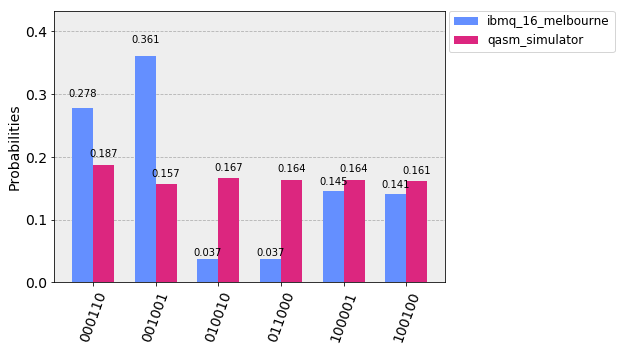

In [16]:
### ibmq_16_melbourne ###

backend = provider.get_backend('ibmq_16_melbourne')

# transpile circuit
transpiled_circuit=transpile(qcircuit,backend=backend,optimization_level=3)

# execute the circuit on the quantum device.
# we've set the number of repeats of the circuit
# to be 2048.
job_exp = execute(transpiled_circuit, backend=backend, shots=2048)
job_monitor(job_exp)

# grab the results from the job.
result_exp = job_exp.result()

exp = result_exp.get_counts(qcircuit)

# only plot probability amplitudes of the exact solution
counts_exp = {}
for key in keys:
    counts_exp[key]=exp.get(key)

plot_histogram([counts_exp,counts], legend=['ibmq_16_melbourne', 'qasm_simulator'])

As we can see, preparing the three-particle Laughlin state is a hard task for the quantum computer, mainly due to the depth of the circuit and the large entanglement generated. Instead of performing tomography, we may use the *state vector simulator* to check whether our circuit is creating the correct quantum state.

In [17]:
### statevector_simulator ###

qcircuit = QuantumCircuit(6)

# prepare the initial |0,1,2> state
qcircuit.x(3)
qcircuit.x(4)

# apply U_ij(p)
U_01(qcircuit,0,1,2,3,4,5)
U_02_1(qcircuit,0,1,2,3,4,5)
U_12_1(qcircuit,0,1,2,3,4,5)
U_02_2(qcircuit,0,1,2,3,4,5)
U_12_2(qcircuit,0,1,2,3,4,5)

backend = Aer.get_backend('statevector_simulator')
job = execute(qcircuit, backend)
result = job.result()
outputstate = result.get_statevector(qcircuit, decimals=3)
print(outputstate)

[ 0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
  0.408+0.j  0.   +0.j  0.   +0.j -0.408+0.j  0.   +0.j  0.   +0.j
  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
 -0.408+0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
  0.408+0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
  0.   +0.j  0.   +0.j  0.   +0.j  0.408+0.j  0.   +0.j  0.   +0.j
 -0.408+0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j
  0.   +0.j  0.   +0.j  0.   +0.j  0.   +0.j]


We can now check that our circuit is exactly generating the three-particle Laughlin state $\left|\psi^{(3)}_L\right\rangle = \frac{1}{\sqrt{6}}\left(\left| 00,01,10\right\rangle - \left| 01,00,10\right\rangle + \left| 01,10,00\right\rangle - \left| 10,01,00\right\rangle + \left| 10,00,01\right\rangle - \left|00,10,01\right\rangle\right)$.

## $n$-particle Laughlin state

For the sake of completeness, we are going to briefly generalize the previous quantum circuits to prepare the $n$-particle Laughlin state. The full circuit that creates the $n$-particle Laughlin state reads

<img src="full_circuit_n.png" width="500px">

The unitary operation $U[n]$ corresponds to the circuit that creates the Laughlin state for $n-1$ particles. Then, the operation $V_n^{[n+1]}$ can be decomposed in terms of the aforementioned $U_{ij}(p)$ as

\begin{align}
V_n^{[n+1]} = U_{0n}(p) U_{1n}(p)...U_{n-1 n}(p)\,,
\end{align}

where the weight $p$ can be determined simply as $p=\frac{1}{n+1}$.

*If you have gone through the whole tutorial, I encourage you to construct and characterize the four-particle Laughlin state!*

***
### *References*

[1] J. I. Latorre, V. Picó and A. Riera, *Quantum algorithm for the Laughlin wave function*, Phys. Rev. A **81**, 060309 (2010), [arXiv:0902.4797](https://arxiv.org/abs/0902.4797).<br>
[2] A. Barenco, C. H. Bennett, R. Cleve, D. P. DiVincenzo, N. Margolus, P. Shor, T. Sleator, J. Smolin and H. Weinfurter, *Elementary gates for quantum computation*, Phys.Rev. A **52**, 3457 (1995), [arXiv:950316](https://arxiv.org/abs/quant-ph/9503016). <br>
[3] C. Bravo-Prieto, D. García-Martín and J. I. Latorre, *Quantum Singular Value Decomposer*, [arXiv:1905.01353](https://arxiv.org/abs/1905.01353). <br>
[4] A. Cervera-Lierta, J. I. Latorre and D. Goyeneche, *Quantum circuits for maximally entangled states*, Phys. Rev. A **100**, 022342 (2019), [arXiv:1904.07955](https://arxiv.org/abs/1904.07955). <br>
[5] Y. Liang, C. Lim and D. Deng, *Reexamination of a multisetting Bell inequality for qudits*, Phys. Rev. A **80**, 052116 (2009), [arXiv:0903.4964](https://arxiv.org/abs/0903.4964). <br>